In [148]:
import yfinance as yf
import numpy as np
import statistics
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
import warnings
warnings.filterwarnings('ignore')
PATH_TO_STOCK = 'data/SSE50.csv'

1. Собрать данные по дневным ценам активов (акций) и дневным объемам продаж на заданном фондовом рынке за указанный период. Добавить (если нет) данные по индексу рынка

2. Преобразовать данные по ценам в данные по доходностям (используйте логарифмическую доходность). Вычислите оценки ожидаемых доходностей и стандартных отклонений и постройте «карту» активов в системе координат (σ, E).

3. Рассмотрите портфель с равными долями капитала и отметьте его на карте активов в системе координат (σ, E). Дайте характеристику этому портфелю.

4. Рассмотрите индекс рынка и отметьте его на карте активов в системе координат (σ,E). Дайте характеристику индексу рынка. PS σ - Risk, E - Expectation

In [18]:
def get_descriptive_statistics(frame):
    E = np.mean(frame["Log_R"])
    sigma = np.std(frame["Log_R"])
    frame['E'] = E
    frame['sigma'] = sigma
    return frame, E, sigma

def get_log_R(frame):
    frame['Log_R'] = np.log(frame['Close'] / frame['Close'].shift(1))
    return frame

In [ ]:
stocks_stat = pd.DataFrame(columns=['sigma', 'E', 'names', 'mean_vol', 'mean_log_R', 'industry'])
stocks_info = pd.read_csv(PATH_TO_STOCK, names=['Name', 'Industry','Symbol'], delimiter=',')
n_stocks = len(stocks_info)
stocks = {}

for index, row in stocks_info.iterrows():
    name, industry, symbol = row
    if name != 'Index':
        symbol = str(symbol) + '.SS'
    stock = yf.download(symbol, start="2018-01-01", end="2018-12-31")
    stock = get_log_R(stock)
    stock, E, s = get_descriptive_statistics(stock)
    mean_vol = stock['Volume'].mean()
        
    stocks_stat.loc[index] = [s, E, name, mean_vol, stock['Log_R'].mean(), industry]
    stocks[str(industry)+'/'+str(name)] = stock

In [91]:
fig = px.scatter(stocks_stat, x="sigma", y="E", hover_data=["names"], color="industry",title="E, Risk", size="mean_vol")

E_balanced = stocks_stat['E'].mean()
sigma_balanced = abs(np.sqrt(np.cov(stocks_stat['mean_log_R'])))
vol_balanced = stocks_stat['mean_vol'].mean()

fig.add_trace(go.Scatter(
    x=[sigma_balanced],
    y=[E_balanced],
    mode="markers+text",
    #name="index",
    text='Balanced portfolio',
    textposition="top center"
))
fig.add_trace(go.Scatter(
    x=stocks_stat[stocks_stat.names == 'Index']['sigma'].values,
    y=stocks_stat[stocks_stat.names == 'Index']['E'].values,
    mode="markers+text",
    #name="index",
    text='Index SSE50',
    textposition="top center"
))
fig.show()
# pio.write_html(fig, file='report/fig1.html', auto_open=True)

## Задание 3-4 (Характеристика индекса рынка  сбалансированного портфеля)

- Индекс рынка SSE50 - индекс топ-50 компаний Shanghai Stock Exchange, отобранных по "отрегулированной" (float-adjusted) капитализации и другим признакам. На графике (fig1.htaml) можно заметить, что индекс (точка Index SSE50) находится в зоне наибольшей концентрации активов ($\sigma [0.01, 0.02], E [-0.0015, 0]$) и тем самым отражает поведение наиболее значимых активов рынка (рамер точки - средний объём продаж за 2018 год), которые принадлежат банкам (см. легенду графика).

- Сбалансированный портфель представляет собой равнодолевой портфель из всех активов индекса SSE50. Стоит отметить, что равнодолевой портфель с успехом деверсифицирует риск акций SSE50 и вложение в него более выгодно, чем в индекс рынка. Для объяснения этого предположения обратимся к определению индекса SSE50: "SSE 50 Index is the stock index of Shanghai Stock Exchange, representing the top 50 companies by "float-adjusted" capitalization and other criteria. In order to qualify as a constituent of SSE 50 Index, it must be a constituent of SSE 180 Index, thus SSE 50 is a subindex of SSE 180 Index."(Wiki). Т.е веса, которые даны активам в SSE50, которые должны отражать тенденции SSE180 и всего SSE нацелены на отражение тенденций, что и показано на графике. Если же мы рассматриваем целесообразность инвестиций, то для нас больший интерес представляет равнодолевой портфель, т.к он находится на одном уровне доходности с индексом SSE50, но имеет практически минимальный риск.



7. Выберите несколько интересных (значимых) активов рынка из разных производственных секторов. В предположении, что наблюдаемые доходности (объемы продаж) являются повторной выборкой из некоторого распределения исследовать (выборочно) распределения доходностей и объемов продаж выбранных активов. Сделать выводы.

In [146]:
from scipy.stats import norm
stocks_names = ['Banking/Bank of Jiangsu', 
                'Automotive/SAIC Motor', 
                'Construction/China Railway Construction ', 
                'Oil & gas/PetroChina',
                'Telecommunication/China United Network Communications']
def plot_R_vs_Norm_distribution(label):
    stock = stocks[label]
    stock['Log_R'].hist(bins=30, normed=True,histtype="stepfilled",alpha=0.5)
    E = stock['E'].values[0]
    sigma = stock['sigma'].values[0]
    x = np.linspace(E - 3*sigma, E+3*sigma,100)
    plt.plot(x, scipy.stats.norm.pdf(x, E, sigma), "r")
    plt.title("{} returns ({} industry) vs. normal distribution".format(label.split('/')[1], label.split('/')[0]))
    plt.show()

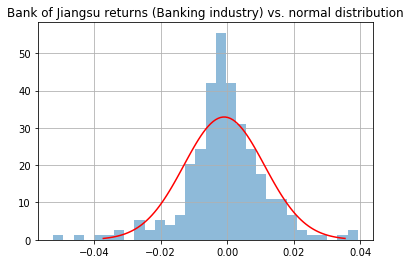

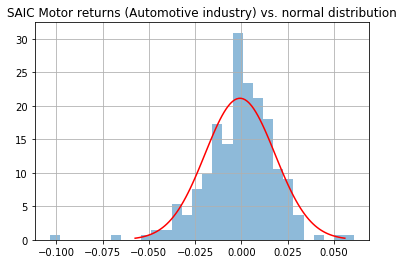

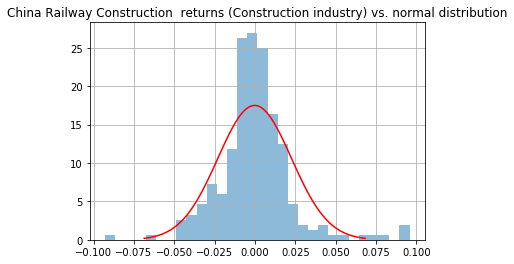

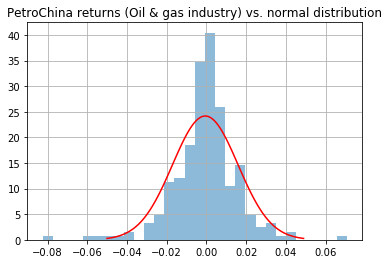

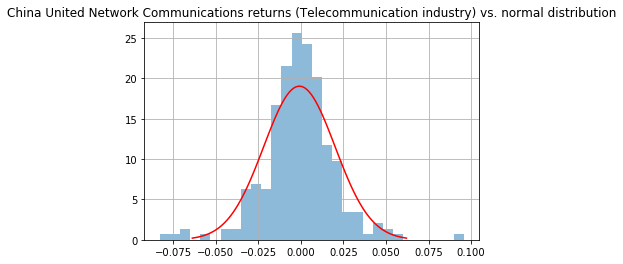

In [149]:
for label in stocks_names:
    plot_R_vs_Norm_distribution(label)

In [130]:

stocks[stocks_names[2]]

KeyError: 'Construction/China Railway Construction'

In [132]:
stocks.keys()

dict_keys([' Other/Tsinghua Tongfang', 'Other/Xinwei Group', 'Airline/China Southern Airlines', 'Automotive/SAIC Motor', 'Banking/Shanghai Pudong Development Bank', 'Banking/China Minsheng Bank', 'Banking/China Merchants Bank', 'Banking/Bank of Jiangsu', 'Banking/Industrial Bank', 'Banking/Bank of Beijing', 'Banking/Bank of Shanghai', 'Banking/Agricultural Bank of China', 'Banking/Bank of Communications', 'Banking/Industrial and Commercial Bank of China', 'Banking/China Everbright Bank', 'Banking/Bank of China', ' Beverages/Kweichow Moutai', 'Construction/China Railway Construction ', 'Construction/China Railway [Engineering] ', 'Construction/China State Construction Engineering ', 'Construction/China Communications Construction ', 'Dairy/Yili Group', 'Energy/China Shenhua Energy ', 'Energy/China National Nuclear Power ', 'Financial services/CITIC Securities', 'Financial services/Haitong Securities', 'Financial services/Orient Securities', 'Financial services/China Merchants Securities